# YOLOv8 Image Segmentation

## Environment preparation

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/YOLOv8/3_image_segmentation

/content/drive/MyDrive/YOLOv8/3_image_segmentation


In [3]:
%pip install ultralytics
import ultralytics
ultralytics.checks()


Ultralytics YOLOv8.2.82 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 33.7/78.2 GB disk)


## Test / Prediction

In [ ]:
!yolo segment predict model=yolov8x-seg.pt source='https://ultralytics.com/images/bus.jpg'


100% 137M/137M [00:00<00:00, 202MB/s]
Ultralytics YOLOv8.2.78 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8x-seg summary (fused): 295 layers, 71,797,696 parameters, 0 gradients, 344.1 GFLOPs

100% 134k/134k [00:00<00:00, 21.2MB/s]
image 1/1 /content/drive/MyDrive/YOLOv8/3_image_segmentation/bus.jpg: 640x480 5 persons, 1 bus, 92.9ms
Speed: 12.9ms preprocess, 92.9ms inference, 963.7ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs/segment/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


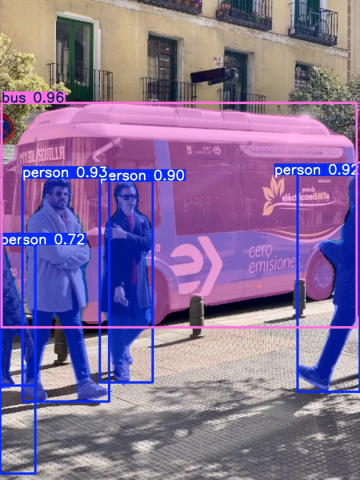

In [ ]:
import cv2
import imutils
from google.colab.patches import cv2_imshow

image_path="/content/drive/MyDrive/YOLOv8/3_image_segmentation/runs/segment/predict/bus.jpg"

img=cv2.imread(image_path)
img=imutils.resize(img,width=360)
cv2_imshow(img)

In [ ]:
import cv2
import imutils
import numpy as np
from ultralytics import YOLO
from google.colab.patches import cv2_imshow

In [ ]:
# data extraction block
def extract_data(img,model):
  h,w,ch=img.shape
  results=model.predict(source=img.copy(),save=False,save_txt=False)
  result=results[0]
  seg_contour_idx=[]

  for seg in result.masks.xyn:
    seg[:,0]=seg[:,0]*w
    seg[:,1]=seg[:,1]*h
    segment=np.array(seg,dtype=np.int32)
    seg_contour_idx.append(segment)

  bboxes=np.array(result.boxes.xyxy.cpu(),dtype='int')
  class_ids=np.array(result.boxes.cls.cpu(),dtype='int')
  scores=np.array(result.boxes.conf.cpu(),dtype='float').round(2)

  return bboxes,class_ids,seg_contour_idx,scores



0: 640x480 4 persons, 1 bus, 1 tie, 71.2ms
Speed: 2.0ms preprocess, 71.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 480)


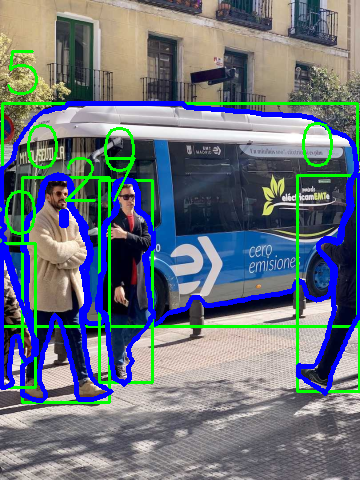

In [ ]:

img_path="bus.jpg"
model_path="yolov8x-seg.pt"
font=cv2.FONT_HERSHEY_SIMPLEX

img=cv2.imread(img_path)
img=imutils.resize(img,width=360)

model=YOLO(model_path)

# data extraction
bboxes,class_ids,seg_contour_idx,scores=extract_data(img,model)

for box,class_id,segmentation_id,score in zip(bboxes,class_ids,seg_contour_idx,scores):
  (xmin,ymin,xmax,ymax)=box

  cv2.rectangle(img,(xmin,ymin),(xmax,ymax),(0,255,0),2)
  cv2.polylines(img,[segmentation_id],True,(255,0,0),3)
  cv2.putText(img,str(class_id),(xmin,ymin-10),font,2,(0,255,0),2)

cv2_imshow(img)


0: 640x480 4 persons, 1 bus, 1 tie, 92.0ms
Speed: 3.6ms preprocess, 92.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


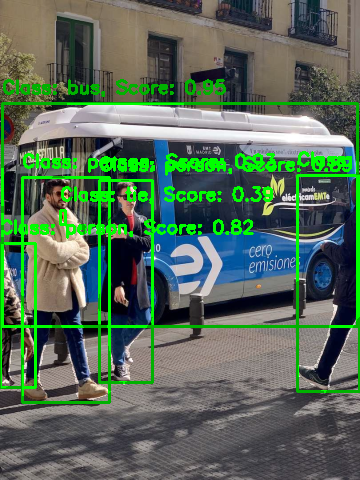

In [ ]:

img_path = "bus.jpg"
model_path = "yolov8x-seg.pt"
font = cv2.FONT_HERSHEY_SIMPLEX

img = cv2.imread(img_path)
img = imutils.resize(img, width=360)

model = YOLO(model_path)

bboxes, class_ids, seg_contour_idx, scores = extract_data(img, model)

mask = np.zeros_like(img)

for box, class_id, segmentation_id, score in zip(bboxes, class_ids, seg_contour_idx, scores):
    (xmin, ymin, xmax, ymax) = box

    cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)

    cv2.fillPoly(mask, [segmentation_id], (255, 255, 255))

    class_name = model.names[class_id]
    text = f"Class: {class_name}, Score: {score:.2f}"
    cv2.putText(img, text, (xmin, ymin - 10), font, 0.6, (0, 255, 0), 2)

masked_img = cv2.bitwise_and(img, mask)
combined = cv2.addWeighted(img, 0.7, masked_img, 0.3, 0)
cv2_imshow(combined)


## Car Part Training

In [ ]:
!unzip data/car_part_dataset.zip -d data

Archive:  data/car_part_dataset.zip
replace data/car_part_dataset/images/test/1003.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!yolo segment train data=data/config.yaml model=yolov8n-seg.pt epochs=20 imgsz=640 workers=8 batch=8 device=0 name=yolov8_car_part_segmentation


Ultralytics YOLOv8.2.81 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=segment, mode=train, model=yolov8n-seg.pt, data=data/config.yaml, epochs=20, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=yolov8_car_part_segmentation, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_co

In [ ]:
#!yolo segment train model=".../last.pt" resume=True

## Car Part Test / Prediction


In [ ]:
!yolo segment predict model=runs/segment/yolov8_car_part_segmentation/weights/best.pt source="data/car_part_dataset/images/test" save=True

Ultralytics YOLOv8.2.81 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n-seg summary (fused): 195 layers, 3,259,819 parameters, 0 gradients, 12.0 GFLOPs

image 1/176 /content/drive/MyDrive/YOLOv8/3_image_segmentation/data/car_part_dataset/images/test/1003.jpg: 640x640 1 back_bumper, 1 back_glass, 2 back_lights, 9.6ms
image 2/176 /content/drive/MyDrive/YOLOv8/3_image_segmentation/data/car_part_dataset/images/test/1008.jpg: 640x640 1 front_bumper, 1 front_glass, 2 front_lights, 1 hood, 45.6ms
image 3/176 /content/drive/MyDrive/YOLOv8/3_image_segmentation/data/car_part_dataset/images/test/1009.jpg: 640x640 1 back_bumper, 1 back_door, 1 back_glass, 1 back_light, 1 front_door, 15.7ms
image 4/176 /content/drive/MyDrive/YOLOv8/3_image_segmentation/data/car_part_dataset/images/test/1012.jpg: 640x640 1 back_bumper, 1 back_glass, 2 back_lights, 10.8ms
image 5/176 /content/drive/MyDrive/YOLOv8/3_image_segmentation/data/car_part_dataset/images/test/1015.jpg: 640x640 1 back_bu

In [4]:
import cv2
import imutils
import numpy as np
from ultralytics import YOLO
from google.colab.patches import cv2_imshow

In [5]:
# data extraction block
def extract_data(img,model):
  h,w,ch=img.shape
  results=model.predict(source=img.copy(),save=False,save_txt=False)
  result=results[0]
  seg_contour_idx=[]

  for seg in result.masks.xyn:
    seg[:,0]=seg[:,0]*w
    seg[:,1]=seg[:,1]*h
    segment=np.array(seg,dtype=np.int32)
    seg_contour_idx.append(segment)

  bboxes=np.array(result.boxes.xyxy.cpu(),dtype='int')
  class_ids=np.array(result.boxes.cls.cpu(),dtype='int')
  scores=np.array(result.boxes.conf.cpu(),dtype='float').round(2)
  class_names=result.names

  return bboxes,class_ids,seg_contour_idx,scores,class_names


0: 352x640 1 back_door, 1 back_glass, 1 front_bumper, 1 front_door, 1 front_glass, 1 front_light, 1 hood, 108.4ms
Speed: 7.0ms preprocess, 108.4ms inference, 724.1ms postprocess per image at shape (1, 3, 352, 640)


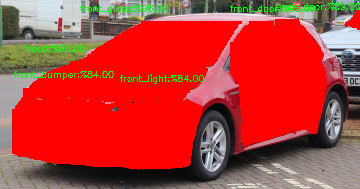

In [6]:
img_path= "inference/test.jpg"
model_path= "runs/segment/yolov8_car_part_segmentation/weights/best.pt"
font=cv2.FONT_HERSHEY_SIMPLEX

img=cv2.imread(img_path)
img=imutils.resize(img,width=360)

model=YOLO(model_path)

# data extraction
bboxes,class_ids,seg_contour_idx,scores,class_names=extract_data(img,model)

for box,class_id,segmentation_id,score in zip(bboxes,class_ids,seg_contour_idx,scores):
  (xmin,ymin,xmax,ymax)=box

  #cv2.rectangle(img,(xmin,ymin),(xmax,ymax),(0,255,0),2)
  #cv2.polylines(img,[segmentation_id],True,(255,0,0),3)
  cv2.fillPoly(img,pts=[segmentation_id],color=((0,0,255)))
  class_name=class_names[class_id]
  score=score*100
  text=f"{class_name}:%{score:.2f}"
  cv2.putText(img,str(text),(xmin,ymin-10),font,0.3,(0,255,0),1)

cv2_imshow(img)